<a href="https://colab.research.google.com/github/mwithgod3952/jh_Minor_Projects/blob/main/gf_learn_tx_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly
!pip install EIA-python
!pip install changefinder
!pip install ruptures
!pip install gensim
!pip show gensim

In [4]:
import os
from tqdm.notebook import tqdm
import pickle
import openpyxl

import collections
import pandas as pd
import numpy as np
from copy import deepcopy
import math
from math import log
import ast
import re

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction import text

import eia
import changefinder
import ruptures as rpt

import torch
import torch.nn.functional as F

# Visualization
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Word2vec
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)
from gensim.models import word2vec

# change point
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

2021-09-29 02:38:46,136 : INFO : 'pattern' package not found; tag filters are not available for English


In [5]:
print(f'\t - Current Working Directory : {os.getcwd()}')

os.chdir('/content/drive/MyDrive/gf_learned_tx')
print(f'\t - Directory changed to : {os.getcwd()}')

	 - Current Working Directory : /content
	 - Directory changed to : /content/drive/MyDrive/gf_learned_tx


##### ***- 유사도 분석을 목적으로 비교군 데이터 로딩***

In [6]:
main_dir = os.getcwd()
pth_ind_co_dat = [x for x in range(len(os.listdir())) if os.listdir()[x][-6:-4] == 'cp'][0]
fl_gf_dt_cp = pd.read_csv(main_dir + '/' +  os.listdir()[pth_ind_co_dat])

fl_gf_dt_cp.columns = ['brand', 'stuff_name']

# brand name의 앞 뒤 공백제거 
fl_gf_dt_cp.brand = [fl_gf_dt_cp.brand[x].strip() for x in range(len(fl_gf_dt_cp))]

# scaping 중 발생한 각 row별 중복 값 제거 
for i, row in fl_gf_dt_cp.iterrows():
    ech_row = ast.literal_eval(row.stuff_name)
    fl_gf_dt_cp.iloc[i, 1] = list(set(ech_row))

fl_gf_dt_cp_OV = fl_gf_dt_cp.copy()    
fl_gf_dt_cp.tail(1)

,brand,stuff_name
1847,미쉘메르시에,[]


In [7]:
fl_gf_dt_uq = fl_gf_dt_cp.iloc[ [x for x in range(len(fl_gf_dt_cp)) if fl_gf_dt_cp.iloc[x, 1] != []], : ] 
fl_gf_dt_uq = fl_gf_dt_uq.drop_duplicates(['brand']).copy(); print(f'\t 제거된 행의 수 (ISSUE_ 1) 중복, 2) 기준 쇼핑몰 및 비교군 쇼핑몰 간 취급하는 브랜드 다름) : {len(fl_gf_dt_cp_OV) - len(fl_gf_dt_uq)}')

# ------------------------------------------ 

fl_gf_dt_uq_OV = fl_gf_dt_uq.copy()

	 제거된 행의 수 (ISSUE_ 1) 중복, 2) 기준 쇼핑몰 및 비교군 쇼핑몰 간 취급하는 브랜드 다름) : 466


In [8]:
res_mi_lst = []
for x in range(1, len(fl_gf_dt_uq)): 
    if (fl_gf_dt_uq.index[x] - fl_gf_dt_uq.index[x-1]) > 1:
        
        missing_ind_lst = []
        for i in range(fl_gf_dt_uq.index[x-1]+1, fl_gf_dt_uq.index[x]):
            missing_ind_lst.append(i)
        res_mi_lst.append(missing_ind_lst)

In [9]:
res_ck = len(fl_gf_dt_cp.iloc[1694:, 1]) == len([x for x in list(fl_gf_dt_cp.iloc[1694:, 1]) if x == []])
res_mi_lst = sum(res_mi_lst, [])

if res_ck == True: total_len_removal = (len(res_mi_lst) + len(fl_gf_dt_cp.iloc[1694:,:])) ;print(f'\t brand 열의 제거된 인덱스의 수 : {total_len_removal}')

	 brand 열의 제거된 인덱스의 수 : 466


In [10]:
res_mi_lst_fl = sum([res_mi_lst, list(fl_gf_dt_cp.iloc[1694:,:].index)], [])

In [11]:
# 해당 제거된 브랜드 데이터 204개의 경우 수기 매핑 진행할 것임으로 삭제된 브랜드 인덱스만 따로 추출하여 저장
with open(os.getcwd() + '/' + 'res_mi_lst_fl.txt', 'wb') as fp:
    pickle.dump(res_mi_lst_fl, fp)

---

##### ***- 유사도 분석을 목적으로 기준 데이터 로딩 및 1차 브랜드 네임 전처리***

In [12]:
fl_nv_dt_or = pd.read_csv([x for x in os.listdir() if x[:7] =='final_p'][0])
stat_path = os.getcwd() + '/' +  [x for x in os.listdir() if x[-10:-4] == 'status'][0]

fl_nv_dt_or['sales_status'] = pd.read_csv(stat_path).product_status.tolist()
fl_nv_dt_or_cp_V = fl_nv_dt_or.copy()
    
if '브랜드' in fl_nv_dt_or.columns:
    fl_nv_dt_or = fl_nv_dt_or.rename(columns = {'브랜드':'brand'})
else:
    fl_nv_dt_or = fl_nv_dt_or.copy()              
    
# ------------------------------------------ 브랜드 정보가 nan인 경우에 대해 미리 handling해둔 브랜드 정보로 fill_na        

fl_nv_dt_or.iloc[:, 4] = list(pd.read_csv(os.getcwd() + '/' + [x for x in os.listdir() if x[:7] == 'final_b'][0]).brand)

print('\t -- df_total_length : ', len(fl_nv_dt_or)); print(); fl_nv_dt_or.tail(1)

	 -- df_total_length :  32465



,title,link,상품번호,상품상태,brand,모델명,이벤트,사은품,원산지,사용부위,혜택조건,주요제품특징,제조사,품목,방식,타입,효과,마사지모드,충전방식,부가기능,전원,무게,색상,편의기능,세부제품특징,사용시간,용량,용기형태,피부타입,용도,시술모드,출력조절,추가구성,아트재료,아트도구,디자인,제조일자,PA지수,자외선차단지수,제품형태,...,매수,강도조절,1회사용시간,표시램프,이발기날,날조절,높이조절,안전기능,빗살캡,코드길이,온도조절,네일 영양제 타입,네일 영양제 효과,구분,개당중량,회전모드,충전식,진동,모드,속도조절,재질,건전지식,자동전원차단,회전,열판,온도조절여부,소음,자동타이머,소재,측정내용,풍량조절,온도조절방식,발생성분,원료,착용형태,구성,히터,온도표시,타이머,sales_status
32464,스칼프메드 레드캡슐바이옴 두피케어 2종세트 (샴푸 400mlx2 + 트리트먼트 40...,https://shopping.naver.com/beauty/stores/10121...,5.629379e+09,신상품,스칼프메드,레드캡슐바이옴,NaN,NaN,국산(세종특별자치시),NaN,NaN,머릿결개선,한국콜마,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


<span style="color:blue">*- 기존 'fl_nv_dt_or'의 경우 네이버 뷰티윈도의 상품 카테고리 분류에 기준하여 상품리스트를 스크래핑한 산출물, 상품 타이틀 내 오타 또는 약어 등이 포함되어 있음을 확인, 따라서 올바른 브랜드 정보를 확립하기 위해 오류 정보의 패턴을 파학 및 'fl_nv_dt_or'의 브랜드 정보를 수기 수정한 데이터로 대체하기를 결정*</span>

<span style="color:blue">*- 기준이 되는 원 데이터와 비교군이 되는 쇼핑몰(ex_ glowpick) 사이에 모든 상품이 동일 업로드 되어 있진 않음을 확인, 이런 이유로 스크래핑 과정에서 특정 행들을 미리 필터링하도록 자동화 및 추출해 두었으며, 해당 행은 모델학습에서 삭제하기로 결정*</span>

In [13]:
print('\t - number of total values of brand : ', len(fl_gf_dt_uq.brand)); print('\t\t - number of unique values of brand : ', len(set(fl_gf_dt_uq.brand)))

	 - number of total values of brand :  1382
		 - number of unique values of brand :  1382


In [14]:
dict_brd_ind    = collections.defaultdict(list)

for brd in list( set(fl_nv_dt_or.iloc[:,4]) ):
    dict_brd_ind[brd].append( fl_nv_dt_or[fl_nv_dt_or.iloc[:,4] == brd].index.tolist() )
    
type(dict_brd_ind)

collections.defaultdict

In [15]:
not_valid_brds = [x for x in list(fl_nv_dt_or.brand) if x not in list(fl_gf_dt_uq.brand)]
not_valid_brds = list(set(not_valid_brds))

error = []
for x in not_valid_brds:
    try:
        fl_nv_dt_or.drop(dict_brd_ind[x][0], inplace=True)
    except:
        print(f'An error occurred while removing information of {x}')
        error.append(x)
        pass

In [16]:
print(f'\t - number of rows deleted == {len(fl_nv_dt_or_cp_V) - len(fl_nv_dt_or)}')
print(f'\t - number of errors == {len(error)}')

fl_nv_dt_or_res = fl_nv_dt_or.copy()

	 - number of rows deleted == 2929
	 - number of errors == 0


In [17]:
fl_nv_dt_or_res_OV = fl_nv_dt_or_res.copy()
fl_nv_dt_or_res = fl_nv_dt_or_res[fl_nv_dt_or_res.sales_status != -1].copy()

print(f'\t - Number fo products currently not on sale == {len(fl_nv_dt_or_res_OV) - len(fl_nv_dt_or_res)}')

2021-09-29 03:00:20,659 : INFO : NumExpr defaulting to 2 threads.


	 - Number fo products currently not on sale == 1346


In [18]:
idx = 0
for i in range(len(fl_nv_dt_or_res)):
    if str(fl_nv_dt_or_res.iloc[i, 4]) not in str(fl_nv_dt_or_res.iloc[i, :].title):
        idx += 1
        
print(f'\t - Number of rows where the brand name is missing or incorrectly entered in the product title == , {idx}')
print(f'\t - Number of rows where the brand name is clearly included in the product title == , {len(fl_nv_dt_or_res) - idx}')

	 - Number of rows where the brand name is missing or incorrectly entered in the product title == , 3061
	 - Number of rows where the brand name is clearly included in the product title == , 25129


In [19]:
word_len_one_sum_count, word_len_two_sum_count = [],[]

word_len_one, word_len_two = [],[]
word_inc_one, word_inc_two = [],[]

for idx, row in fl_nv_dt_or_res.iterrows():
    
    if row.brand in row.title:
        if len(row.brand) == 1:
            word_len_one.append(row.brand)
            if row.brand in row.brand:
                word_len_one_eac_count = []

                target_brd = row.brand
                target_tlt = row.title

                for ts in range(1, len(target_tlt)):
                    if target_brd == target_tlt[ts-1 : ts]:
                        word_len_one_eac_count.append(1)
                    if ts == len(target_tlt)-1:
                        if target_brd == target_tlt[-1]:
                            word_len_one_eac_count.append(1)
                word_len_one_sum_count.append(sum(word_len_one_eac_count))
                word_inc_one.append(row.brand)
                
        elif len(row.brand) == 2:
            word_len_two.append(row.brand)
            if row.brand in row.brand:
                word_len_two_eac_count = []
                
                target_brd = row.brand
                target_tlt = row.title
                
                for x, y in  zip([x for x in range(len(target_tlt)-1)], [x for x in range(1, len(target_tlt))]):
                    if target_brd == str(target_tlt[x] + target_tlt[y]):
                        word_len_two_eac_count.append(1)
                word_len_two_sum_count.append(sum(word_len_two_eac_count))
                word_inc_two.append(row.brand)

print('\t Whether the one-letter brand name is included in the product title : ', len(word_len_one) == len(word_inc_one))
if (len(word_len_one_sum_count) == len(word_inc_one)): TorF = False
print(f'\t\t If the brand name is included in the product title, check whether it is included repeatedly : {TorF}'); print()

print('\t Whether the two-letter brand name is included in the product title : ', len(word_len_two) == len(word_inc_two)) 
if (len(word_len_two_sum_count) == len(word_inc_two)): TorF = False
print(f'\t\t If the brand name is included in the product title, check whether it is included repeatedly : {TorF}')

	 Whether the one-letter brand name is included in the product title :  True
		 If the brand name is included in the product title, check whether it is included repeatedly : False

	 Whether the two-letter brand name is included in the product title :  True
		 If the brand name is included in the product title, check whether it is included repeatedly : False


In [20]:
for idx, row in fl_nv_dt_or_res.iterrows():
    if row.brand in row.title:
        fl_nv_dt_or_res.loc[idx, 'title'] = row.title.replace(row.brand, '')

In [21]:
print('Example) _ ')
print(f'\t {fl_nv_dt_or.iloc[2, :].title}'); print(f'\t\t {fl_nv_dt_or_res.iloc[2, :].title}')

Example) _ 
	 헤라 NEW블랙쿠션SPF34/PA++15gx2(본품1개+리필1개)+[N페이 3천점]
		  NEW블랙쿠션SPF34/PA++15gx2(본품1개+리필1개)+[N페이 3천점]


---

##### ***- 데이터 전처리***

<span style="color:blue">*- 해당 TF-IDF의 모델의 경우 일치하는 단어를 기준하여 유사도를 판별, 이런 이유로 유사도에 직접적으로 기여할 수 있는 제품 타이틀 명에 대해 잘못 기입된 특정 패턴을 dictionary화*</span>

In [22]:
brd_en_kr_dict = {
    'iunik':'아이유닉',
    'CHILFACE':'7FACE',
    'Physis':'피시스',
    'INGA':'잉가',
    'mixsoon':'믹순',
    'RAUSCH':'라우쉬',
    'SNP':'에스앤피',
    'jeen':'진',
    'CNC코스메틱': 'cNc',
    'Phymongshe':'피몽쉐',
    'JEEN':'진',
    'EUNYUL':'은율',
    'VDL':'브이디엘',
    'NEEDLY':'니들리',
    'BODYROUTINE':'바디루틴',
    'herbalfacefood':'허벌페이스푸드',
    'BARREL':'배럴',
    'FLALIA':'플라리아',
    'LUSH':'러쉬',
    'phykology':'파이콜로지',
    'ODYSSEY':'오딧세이',
    'Nouvelle Derm':'누벨덤',
    'A.black':'에이블랙',
    'IUNIK':'아이유닉',
    'PARISSA':'페리샤',
    'BABOR':'바버',
    'DS래보래토리즈':'디에스랩',
    'Calatas':'칼라타스',
    'HOURGLASS':'아워글래스',
    'Emma Hardie':'엠마하디',
    'LAPCOS':'랩코스',
    'ANNETBRUSH':'아넷브러쉬',
    'REDDY':'레디',
    'ellips':'엘립스',
    'HAU':'하우',
    'PW솔루션':'피더블유',
    'RAIP':'라입',
    'lovea':'로베아',
    'MERZY':'머지',
    'RATE':'레이트',
    'HYGGEE':'휘게',
    'MEDIPICKME':'메디픽미',
    'JM솔루션':'제이엠솔루션',
    'FARFALLA':'파팔라',
    'NTMT':'엔티엠티',
    'Wednesday':'웬즈데이',
    'koelcia':'코엘시아',
    'JENIA':'제니아',
    'MUSTEM':'뮤스템',
    'AN12':'에이엔12',
    'LUK':'룩',
    'Ogi':'오지아이',
    'MEDIMINE':'메디마인',
    'HEYBRO':'헤이브로',
    'Bluecell':'블루셀',
    'LUNA':'루나',
    'heartpercent':'하트퍼센트',
    'LOIVIE':'로이비',
    'CNP': '차앤박',
    'Emma Hardie': '엠마하디',
    'LaF': 'LAF',
    'ZEMU': '제무',
    '구디': 'Goody',
    '끌로에': 'Chlo',
    '네츄럴샤인': 'NS',
    '다노클리닉': '다노',
    '닥터3': 'DOCTOR.3',
    '더 히스토리 오브 후': '[후]',
    '라온컴퍼니': '라온',
    '랑팔라투르': '랑팔',
    '로맨띠끄': 'LMTQ',
    '로얄헤나': '로얄',
    '릴리트리': '릴리',
    '미프': 'MIP',
    '바버': 'BABOR',
    '배럴코스메틱스': '배럴',
    '버블몬스터': '버몬',
    '브이디엘': 'VDL',
    '비디비치': 'VIDIVICI',
    '비바코리아': '비바',
    '비씨엘': 'BCL',
    '비알티씨': 'BRTC',
    '비에스코스': 'BSKOS',
    '수니': 'SOONI',
    '실크테라피': '실크',
    '씨엘포': 'CL4',
    '씨피원': 'CP-1',
    '아모레퍼시픽': 'AP',
    '아틱': 'ATIC',
    '안나홀츠': '홀츠포맨',
    '언파코스메틱': '언파',
    '에스알비': 'SRB',
    '에스앤피': 'SNP',
    '에스투엔디': 'S2ND',
    '에포나': 'EPONA',
    '에프쓰리 시스템즈': 'F3',
    '엘라스틴': 'ES',
    '엠엘비 코스메틱': 'MLB',
    '오즈비엔에이치': '오즈',
    '웰라 프로페셔널즈': '웰라',
    '자연담은유리병': '자담유',
    '진': 'jeen',
    '칠페이스': '7FACE',
    '키셔': 'KISHER',
    '토스': 'Tous',
    '토아스': 'TOAS',
    '티스': 'TISS',
    '티에스더블유': 'TSW',
    '한조컬렉션': '한조'
}

In [23]:
fl_nv_dt_or_res['copy_brd'] = fl_nv_dt_or_res['brand'].copy()
fl_nv_dt_or_res.tail(1)

,title,link,상품번호,상품상태,brand,모델명,이벤트,사은품,원산지,사용부위,혜택조건,주요제품특징,제조사,품목,방식,타입,효과,마사지모드,충전방식,부가기능,전원,무게,색상,편의기능,세부제품특징,사용시간,용량,용기형태,피부타입,용도,시술모드,출력조절,추가구성,아트재료,아트도구,디자인,제조일자,PA지수,자외선차단지수,제품형태,...,강도조절,1회사용시간,표시램프,이발기날,날조절,높이조절,안전기능,빗살캡,코드길이,온도조절,네일 영양제 타입,네일 영양제 효과,구분,개당중량,회전모드,충전식,진동,모드,속도조절,재질,건전지식,자동전원차단,회전,열판,온도조절여부,소음,자동타이머,소재,측정내용,풍량조절,온도조절방식,발생성분,원료,착용형태,구성,히터,온도표시,타이머,sales_status,copy_brd
32464,레드캡슐바이옴 두피케어 2종세트 (샴푸 400mlx2 + 트리트먼트 400ml),https://shopping.naver.com/beauty/stores/10121...,5.629379e+09,신상품,스칼프메드,레드캡슐바이옴,NaN,NaN,국산(세종특별자치시),NaN,NaN,머릿결개선,한국콜마,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,스칼프메드


<span style="color:blue">*- dict 정보에 기반하여 잘못 기입된 제품 타이틀의 정보를 추출및 추후 수정하기 위한 목적으로 title내의 특정 브랜드 정보를 따로 추출 및 비교군 데이터의 바른 브랜드명으로 replace*</span>

<span style="color:blue">*- 유사도 분석 중 Accuracy향상이 주된 목적*</span>

In [24]:
# extraction
for idx,row in fl_nv_dt_or_res.iterrows():
    for x in list(brd_en_kr_dict.keys()):
        if x == row['copy_brd']:
            if brd_en_kr_dict[x] in row['title']:
                fl_nv_dt_or_res['copy_brd'][idx] = brd_en_kr_dict[x]

# replace
for idx, row in fl_nv_dt_or_res.iterrows():
    fl_nv_dt_or_res.loc[idx,'title'] = row['title'].replace(row['copy_brd'],'')

<span style="color:blue">*- 패턴 색출이 어려운 이유로, 상품 타이틀에 대해 명확한 브랜드 정보로 대체해주지 못한 경우에 대비하여, 추가적인 전처리 방안을 모색*</span>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzGnk7%2FbtqzLEopozf%2Fy2sOocMySuc4ZZhzbt0Ufk%2Fimg.png">

    - 해당 문제를 해결하기 위해, image processing의 stride와 Convolution에서 아이디어를 착안하여 해당 전처리를 해결.

        : 혼선이 없도록 title에 포함된 브랜드명을 b-title, 브랜드열의 브랜드값을 b-brand로 명칭하겠습니다.
          하단의 코드는 크게 3가지 케이스에 대하여 전처리를 진행합니다. 
          
              * case_1: b-title과 b-brand가 띄어쓰기가 다른 경우, 
              * case_2: b-title이 축약된 b-brand를 포함하고 있는 경우, 
              * case_3: 반대로 b-brand에는 축약된 브랜드 네임이, b-title은 풀 브랜드 네임인 경우
              
        위 세가지 경우 b-title이 브랜드명으로써 인식되지 않는 문제가 발생할 수 있습니다.
        이를 해결하기 위한 대안으로, 3개 이상 연속적으로 공통되는 문자열이 나오면, 유효한 브랜드명으로 판단하기로 기준을 마련하였습니다.
        
        판단을 위해 아래와 같은 과정이 진행됩니다.
        
            * 먼저 title 문자열의 공백을 제거해주고, brand문자열의 공백 또한 제거해줍니다.
            * title 문자열과 brand 문자열 각각을 독립된 문자 리스트로 만들어줍니다.
            * 이후, brand 문자열과 title 문자열 간의 일치 정도에 따라 임의의 ''을 insert하며 strid를 만들어내고 반복적으로 일치여부를 판단하여 title 내의 제거할 문자열을 색출해냅니다.
            
            Example)
            st1_
            ['안','녕','이','니','스','아','이','크','림']
            ['이','니','스','프','리'] 

            st2_
            ['안','녕','이','니','스','아','이','크','림']
            ['' , '이','니','스','프','리']

            st3_
            ['안','녕','이','니','스','아','이','크','림']
            ['' ,'', '이','니','스','프','리']
            
            .
            .
            .

            ['안','녕','이','니','스','아','이','크','림']
            ['' , '','',  '이','니','스','프','리']              

In [25]:
def remove_all_b_in_t(input_tlt = '', input_brd = ''):
    '''
    
    - input_tlt : character string of cosmetic product name
    - input_brd : character string of cosmetic brand name 
    
    - tlt_char_lst       : title 문자열 리스트화 
        +a '색출하고자 하는 문자열'이 '상품 타이틀의 맨 앞단'에 위치할 뿐 아니라, 앞서 언급한 바와 같이 '생략된 단어' 형태로 위치한 경우에 대비하여 임의의 특수문자를 추가
        
    - tlt_strpd_char_lst : title 문자열 리스트화 + 공백제거
    - brd_char_list      : brand 문자열 리스트화 + 공백제거
        
    '''
    input_tlt = '******' + input_tlt
    
    tlt_char_lst       = list(input_tlt)
    tlt_strpd_char_lst = list(input_tlt.replace(' ','')) 
    brd_char_list      = list(input_brd.replace(' ',''))
    
    indices_space = [i for i, x in enumerate(tlt_char_lst) if x == ' ']
    
    for i in range(len(tlt_strpd_char_lst) - len(brd_char_list) + 1):
        idx_ls = []
        for j in range(len(brd_char_list)):
            if tlt_strpd_char_lst[j] == brd_char_list[j]:
                if (len(idx_ls) > 0) and ((idx_ls[-1]+1) != j):
                    break
                else:
                    idx_ls.append(j)
                    
        if len(idx_ls) < 3:
            brd_char_list.insert(0, '')

        else:
            for idx in idx_ls:
                tlt_strpd_char_lst[idx] = '' 

    for idx in indices_space:
        tlt_strpd_char_lst.insert(idx,' ') 

    return(''.join(tlt_strpd_char_lst).replace('*', ''))

In [26]:
for idx in fl_nv_dt_or_res.index:
    input_tlt = fl_nv_dt_or_res.loc[idx, 'title']
    input_brd = fl_nv_dt_or_res.loc[idx, 'copy_brd']
    
    modified_tlt = remove_all_b_in_t(input_tlt, input_brd)
    
    if input_tlt != modified_tlt:
        fl_nv_dt_or_res.loc[idx, 'title'] = modified_tlt

<span style="color:blue">*- 추가 전처리*</span>

    1. 대소문자 변경 및 특수기호 제거

    2. 하나의 벡터로 인식되어야 하는 단어들 (substr_items)에 대하여 앞뒤로 공백 추가
    
    3. 기준 데이터의 타이틀 열에서 반복적으로 나타나는 불용어 (==제품명과 무관한 키워드)를 to_empty 리스트에 넣어 제거
    
    4. 기준 데이터의 타이틀 열에서 공통적으로 발견되는 불용어 패턴들을 정립하고, 바뀐 패턴을 적용
    
***----------------------***

    5. 비교군 데이터의 타이틀 열에서 공통적으로 발견되는 불용어 패턴들을 정립하고, 바뀐 패턴을 적용

In [27]:
substr_items = ['모이스처라이저', '트리트먼트', '하이라이터', '립글로즈', '수분크림', '컨디셔너', '제모기', '클린저', '브러싱', '클렌저', 
                '클렌져', '컨실러', '컴펙트', '리무버', 'spf', '새도우', '컨투어', '소독제', '브러쉬', '탑코트', '세안제', '클렌징', 
                '에센스', '파우더', '디퓨져', '미스트', '선크림', '선크림', '썬크림', '소프너', '에센셜', '올인원', '브로우', '밸런서', '에멀젼', 
                '섀도우', '쉐도우', '스크럽', '하드너', '에멀전', '선스틱', '베이스', '퍼프', '토닉', '토너', '향수', '토닝', '네일', '앰플', 
                '틴트', '로션', '비누', '팩트', '비비', '샴푸', '퍼밍', '쿠션', '닥토','펜슬', '카밍', '유액', '세럼']

to_empty = ['뷰티어워드', '가성비갑', '수분탄력', '남녀노소', '겟잇뷰티', '한정판매', '교차선택', 'best','베스트','재구매율', 
            '안번지는', '1일1팩', 'pick', '올리브영', '무료배송', '출고예정', '후기검증', '외 모음','구매평','오늘출발','본사직영'
            '풀세트', '10대', '20대', 'set','세트', '체험분', '초간단', 'n페이', 'n단독','부탁해', '공식몰', '가려움', '어워드', '신규향', '홈쇼핑', 
            '무첨가', '온종일', '지속력', '끈적임', '네이버', '패키지', '향좋은', '화장품', '깨끗한', 'out', '기획가', 'new', '속보습', '사은품','직수입'
            '세트', '추천', '겸용', '돌파', '적립', '구성', '완료', '단독', '특가', '리필', '납품', '수상', '출시', '본품', '증정', '단품','공식','정품','비건인증', 
            '최대', '모음', '용품', '입고', '고정', '기획', '옵션','쿠폰', '적합', '쇼핑판', '쇼핑백','쇼핑', '없는', '묶음', '특별', '신상', '신형', '혜택']

to_empty_regex = ['no\.*,*\s*1','[0-9]+만회','[0-9]\.[0-9]+\s*g','[0-9]+\s*g','[0-9]+만점','[0-9]+회분','[0-9]+/[0-9]{1,2}~[0-9]*/*[0-9]{1,2}','[0-9]+\.[0-9]{1,2}~[0-9]*\.*[0-9]{1,2}',
                  '[0-9]\s*box','[0-9]\s*박스','n\s*페이','n\s*pay','1\s*위','[0-9]병','1\s*등','[0-9]\s*일','[0-9]천p','[0-9]천점*',
                  '[0-9]+만개','[0-9]+만원','[0-9]+만p','[ㄱ-ㅎ가-힣]+\s*pick','[ㄱ-ㅎ가-힣]+\s*픽한','택\s*[0-9]','[0-9]+\s*color','[0-9]+\s*종','x\s*[0-9]\s*개','총*\s*[0-9]+\s*개당*입*',
                  '[0-9]관왕','[0-9]\.[0-9]\s*ml','[0-9]+\s*m*ml','[0-9]+입','[0-9]\s*kg','[0-9]+가지','[0-9]+,*[0-9]+건',
                  '[0-9]+\.[0-9]+\s*oz','[0-9]+\s*oz','[0-9]+\s*l','[0-9]+\s*매입','[0-9]+\s*매','[0-9]+ea','x\s*[0-9]','택\s*[0-9]','[0-9]+/[0-9]{1,2}','[0-9]\s*\+\s*[0-9]','\+[0-9]']

In [28]:
# 0)
fl_nv_dt_or_res['title'] = fl_nv_dt_or_res['title'].str.lower() 
fl_gf_dt_uq['stuff_name'] = fl_gf_dt_uq['stuff_name'].astype(str).str.lower() 

In [29]:
def verify_change(tlt_org,tlt_aft):
    '''
    - tlt_org: 원제품 타이틀
    - tlt_aft: 전처리 이후 타이틀 
    '''
    count = 0
    for idx in list(tlt_aft.index):
        len_bf = len(set(tlt_org.loc[idx,'title'].split(' ')))
        len_aft = len(set(tlt_aft.loc[idx,'title'].split(' ')))
        if len_bf != len_aft:
            count += 1
    print(f'\t\t - 총 {count}개 행에 적용')

In [30]:
# 1)

print(f'\t - {len(substr_items)}개 아이템 타이틀의 front, back에 공백적용')

tlt_org = fl_nv_dt_or_res[['title']].copy()

for item in substr_items:
    fl_nv_dt_or_res['title'] = fl_nv_dt_or_res.title.replace(to_replace=r"()({})()".format(item), value=r"\1 \2 \3", regex=True)
    
verify_change(tlt_org, fl_nv_dt_or_res)    

	 - 62개 아이템 타이틀의 front, back에 공백적용
		 - 총 11564개 행에 적용


In [31]:
# 2) 

print(f'\t - {len(to_empty)}개 특정 불용어 제거')

tlt_org = fl_nv_dt_or_res[['title']].copy()

for el in to_empty:
    fl_nv_dt_or_res['title'] = fl_nv_dt_or_res.title.str.replace(el, '')

verify_change(tlt_org,fl_nv_dt_or_res) 

	 - 86개 특정 불용어 제거
		 - 총 2666개 행에 적용


In [32]:
# 3)  
print(f'\t - {len(to_empty_regex)}개 패턴에 해당하는 불용어 제거')

tlt_org = fl_nv_dt_or_res[['title']].copy()

for el in to_empty_regex:
    fl_nv_dt_or_res['title'] = fl_nv_dt_or_res.title.replace(to_replace=el, value='', regex=True)

verify_change(tlt_org,fl_nv_dt_or_res) 

	 - 46개 패턴에 해당하는 불용어 제거
		 - 총 17954개 행에 적용


In [33]:
# 4)
fl_nv_dt_or_res['title'] = fl_nv_dt_or_res.title.str.replace(pat=r'[^\w%\.]ㅣ_', repl=r' ', regex=True).replace('ㅣ','',regex=True)
fl_nv_dt_or_res['title'] = fl_nv_dt_or_res.title.replace(to_replace='\s+', value=' ', regex=True)

***----------------------***

In [34]:
# 6) 
fl_gf_dt_uq['stuff_name'] = fl_gf_dt_uq.stuff_name.replace(to_replace='\[단종\]',value='', regex=True)

In [35]:
# 7)
fl_gf_dt_uq['stuff_name'] = fl_gf_dt_uq.stuff_name.replace(to_replace=r'#[+/:)%(&_-]}{', value=r' ', regex=True)
fl_gf_dt_uq['stuff_name'] = fl_gf_dt_uq.stuff_name.replace(to_replace='(\[\s*)([a-zA-Zㄱ-ㅎ가-힣0-9\s*.·]+)(\s*\])', value=r' \2 ', regex=True)
fl_gf_dt_uq['stuff_name'] = fl_gf_dt_uq.stuff_name.replace(to_replace='\s+', value=' ', regex=True)

---

<span style="color:blue">*- 본 프로젝트에서 다루어지는 상위 모든 데이터 처리 과정에서 특정 문자열, 기호 등을 편집, 변경해주는 과정이 다수 포함되어 있었습니다. 이로 인해 발생하게 된 2개 이상에 문장의 앞, 뒤 뿐만 아니라 문장의 중간에 다수 포함되어 있는 공백을 일괄적으로 1개로 처리해주겠습니다.*</span>

In [36]:
gf_stuff_nm_without_b = []
for x in fl_gf_dt_uq.stuff_name:
    a = ast.literal_eval(x)
    b = []
    for y in a:
        y = y.strip()
        y = re.sub(' +', ' ', y)
        
        b.append(y)    
    gf_stuff_nm_without_b.append(b)
    
nv_tlt_nm_without_b = []
for x in fl_nv_dt_or_res.title:
    x = x.strip()
    y = re.sub(' +', ' ', x)
    nv_tlt_nm_without_b.append(y)  
    
fl_gf_dt_uq.iloc[:, 1] = gf_stuff_nm_without_b
fl_nv_dt_or_res.iloc[:, 0] = nv_tlt_nm_without_b    

---

##### ***- Modeling***

<span style="color:blue">*- TF_IDF값에 기준하여 유사도값 도출*</span>

In [37]:
optional_fol_nm  = [os.listdir()[x] for x in range(len(os.listdir())) if os.listdir()[x][:6] == 'an_opt'][0]
optional_fol_path = os.getcwd() + '/' + optional_fol_nm
optional_file_path = [str(f'{optional_fol_path}/{x}') for x in os.listdir(optional_fol_path)]

'''
기준 데이터가 되는 'fl_nv_dt_or_res'는 'package' 또는, Optiont상품을 포함하고 있으며, Optional file들은 만약, 기준 데이터가 되는 상품이 Option요소를 포함하고 있다면, 해당 'Option'들을 scraping함
'''

optional_sum = []
for i in range(len(optional_file_path)):
    
    extrac_tp_col = pd.read_csv(optional_file_path[i]).type_color
    col_string = extrac_tp_col.astype(str)
    extrac_tp_col_fl = extrac_tp_col[col_string != 'nan']
    
    optional_sum.append(extrac_tp_col_fl)
    
df_optional = pd.DataFrame(pd.concat(optional_sum)).sort_index()
df_optional['type_color'] = [eval(x) for x in df_optional.type_color]

# 기존 모델학습에서 삭제하기로 결정한 행과 index를 동일하게 적용하여 학습에 필요한 행을 선택적으로 Filtering.
df_optional = pd.DataFrame(df_optional.type_color[fl_nv_dt_or_res.index.tolist()])

df_optional.tail(1)

,type_color
32464,[H_샴400+샴400+트400]


<font color = 'red'>**<--------------------------->**</font>



In [236]:
target_url = 'https://shopping.naver.com/beauty/stores/1000018323/products/3713391021'

In [239]:
target_df = res_no_options.loc[:, ['title', 'link', 'brand']]
target_df['sub_ind'] = [x for x in range(len(target_df))]
target_df

target_df[target_df.link == target_url]

,title,link,brand,sub_ind
2324,[] 허브 가득한 마스크,https://shopping.naver.com/beauty/stores/10000...,비욘드,1036


In [240]:
list(target_df[target_df.link == target_url].link)

['https://shopping.naver.com/beauty/stores/1000018323/products/3713391021']

In [255]:
input_df = res_no_options
input_row = 1036

i = input_row

nv_row_n = input_df.index[i]; nv_brd = input_df.brand[nv_row_n]; nv_tlt = input_df.title[nv_row_n]
ind_by_gf = list(fl_gf_dt_uq.brand).index(nv_brd); gf_tlt_to_compare = fl_gf_dt_uq.loc[fl_gf_dt_uq.index[ind_by_gf], :].stuff_name

corpus_group = [[nv_tlt, each_gf_tlt] for each_gf_tlt in gf_tlt_to_compare]

# --------------------------------------------------- 0)_ Tokenize

docs = sum([[nv_tlt], gf_tlt_to_compare], [])
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()

vocab_filtered = []
special_characters = "''!@#$%^&*()[]-+?_=,<>/"
for s in vocab:
    if not any(c in special_characters for c in s):
        vocab_filtered.append(s)
        
Vocab = [x for x in vocab_filtered if len(x) > 1]

ind = 0
Docs = []
for x in docs:
    if ind > 0:
        x = x.replace(' ', '')
    Docs.append(x)
    ind =+ 1

# --------------------------------------------------- 1)_ TF-IDF

N = len(Docs)
TF = []
for i in range(N): 
    TF.append([])
    d = Docs[i]
    for j in range(len(Vocab)):
        t = Vocab[j]        
        TF[-1].append(d.count(t))
tf_df = pd.DataFrame(TF, columns = Vocab)

IDF = []
for j in range(len(Vocab)):
    t = Vocab[j]
    c = 0
    for doc in Docs:
        c += t in doc
    each_idf = log(N/(c + 1))
    IDF.append(each_idf)

TF_IDF_list = [[tf_df.iloc[y, x]*IDF[x] for x in range(len(tf_df.columns))] for y in range(len(tf_df))]
cosim_res = []
'''
cosim_res: result of cosine similarity
'''
for i in range(1, len(TF_IDF_list)):
    cosim_res_each = F.cosine_similarity(torch.FloatTensor(TF_IDF_list[0]), torch.FloatTensor(TF_IDF_list[i]), dim=0)
    cosim_res.append(float(cosim_res_each))

cosim_df = pd.DataFrame(cosim_res)
cosim_df = cosim_df.sort_values(0, ascending = False)
cosim_df = cosim_df[cosim_df[0] != 0] 

# --------------------------------------------------- 2)_ Word2Vec

All_Contents  = sum([ [nv_tlt], [ gf_tlt_to_compare[x] for x in cosim_df.index.tolist() ] ], [])
Eacn_Contents = [x.split(' ') for x in All_Contents]

w2v_tokens = []
for se in Eacn_Contents:
    token = []
    for tk in se:
        if tk in tf_df.columns.tolist():
            token.append(tk)
    w2v_tokens.append(token)

model = word2vec.Word2Vec(w2v_tokens, min_count=1)
similar_tokens = []    
for ref_tokens in w2v_tokens[0]:
    similar_tokens.append([x[0] for x in model.wv.most_similar(ref_tokens)])
tk_extra_f_w2v = list(set(sum(similar_tokens, [])))

w2v_count_list = []
d = All_Contents[1:]
for y in d: 
    idx = 0
    for t in tk_extra_f_w2v:
        if t in y:
            idx +=1
    w2v_count_list.append(idx)

w2v_cosim_result = [np.square(x + y) for x, y in zip(list(cosim_df[0]), [(n/len(model.wv.vocab)) * (1/10) for n in w2v_count_list])]
print(); print(f'\t {w2v_cosim_result}')

# -------------------------------------------------b-- 3)_ Baysian witchpoint


2021-09-29 08:09:05,703 : INFO : collecting all words and their counts
2021-09-29 08:09:05,706 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-29 08:09:05,708 : INFO : collected 47 word types from a corpus of 121 raw words and 32 sentences
2021-09-29 08:09:05,710 : INFO : Loading a fresh vocabulary
2021-09-29 08:09:05,713 : INFO : effective_min_count=1 retains 47 unique words (100% of original 47, drops 0)
2021-09-29 08:09:05,714 : INFO : effective_min_count=1 leaves 121 word corpus (100% of original 121, drops 0)
2021-09-29 08:09:05,716 : INFO : deleting the raw counts dictionary of 47 items
2021-09-29 08:09:05,718 : INFO : sample=0.001 downsamples 47 most-common words
2021-09-29 08:09:05,719 : INFO : downsampling leaves estimated 27 word corpus (22.8% of prior 121)
2021-09-29 08:09:05,721 : INFO : estimated required memory for 47 words and 100 dimensions: 61100 bytes
2021-09-29 08:09:05,722 : INFO : resetting layer weights
2021-09-29 08:09:05,748 : 


	 [0.5787822382978544, 0.5463245009565193, 0.5074553954903751, 0.510491237470416, 0.5074553954903751, 0.443942551877716, 0.4179114993249615, 0.1774571450833579, 0.17566909063070957, 0.17660190111551874, 0.1637164990847015, 0.1637164990847015, 0.1637164990847015, 0.1648893458393392, 0.15655384582171417, 0.1548746754855024, 0.15655384582171417, 0.1548746754855024, 0.1548746754855024, 0.11525962578826561, 0.11569347875693246, 0.07908524909018887, 0.07436990968422375, 0.07195787755632109, 0.04433618763928671, 0.03648757261761064, 0.03648757261761064, 0.0333173361943994, 0.030586196293187977, 0.01846136740838555, 0.015932879563309382]


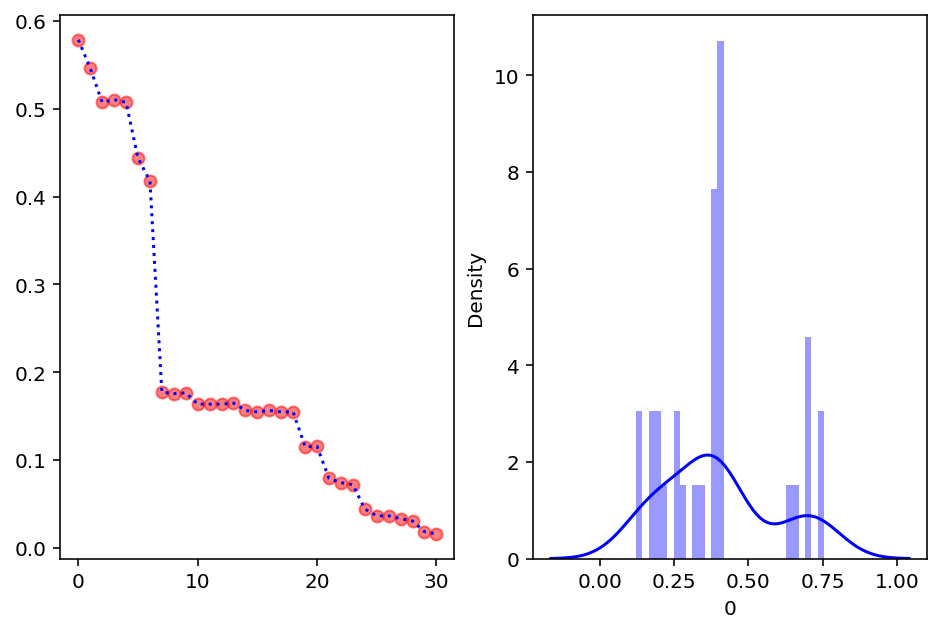

In [256]:
# plt.title([corpus_group[x] for x in cosim_df.index.tolist()])
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter([x for x in range(len(w2v_cosim_result))], w2v_cosim_result, color='r', alpha=0.5, zorder=1)
plt.plot([x for x in range(len(w2v_cosim_result))], w2v_cosim_result, color='b', linestyle=':', zorder=2)

plt.subplot(1, 3, 2)
sns.distplot(cosim_df[0],bins=30 , color='b')

plt.show()

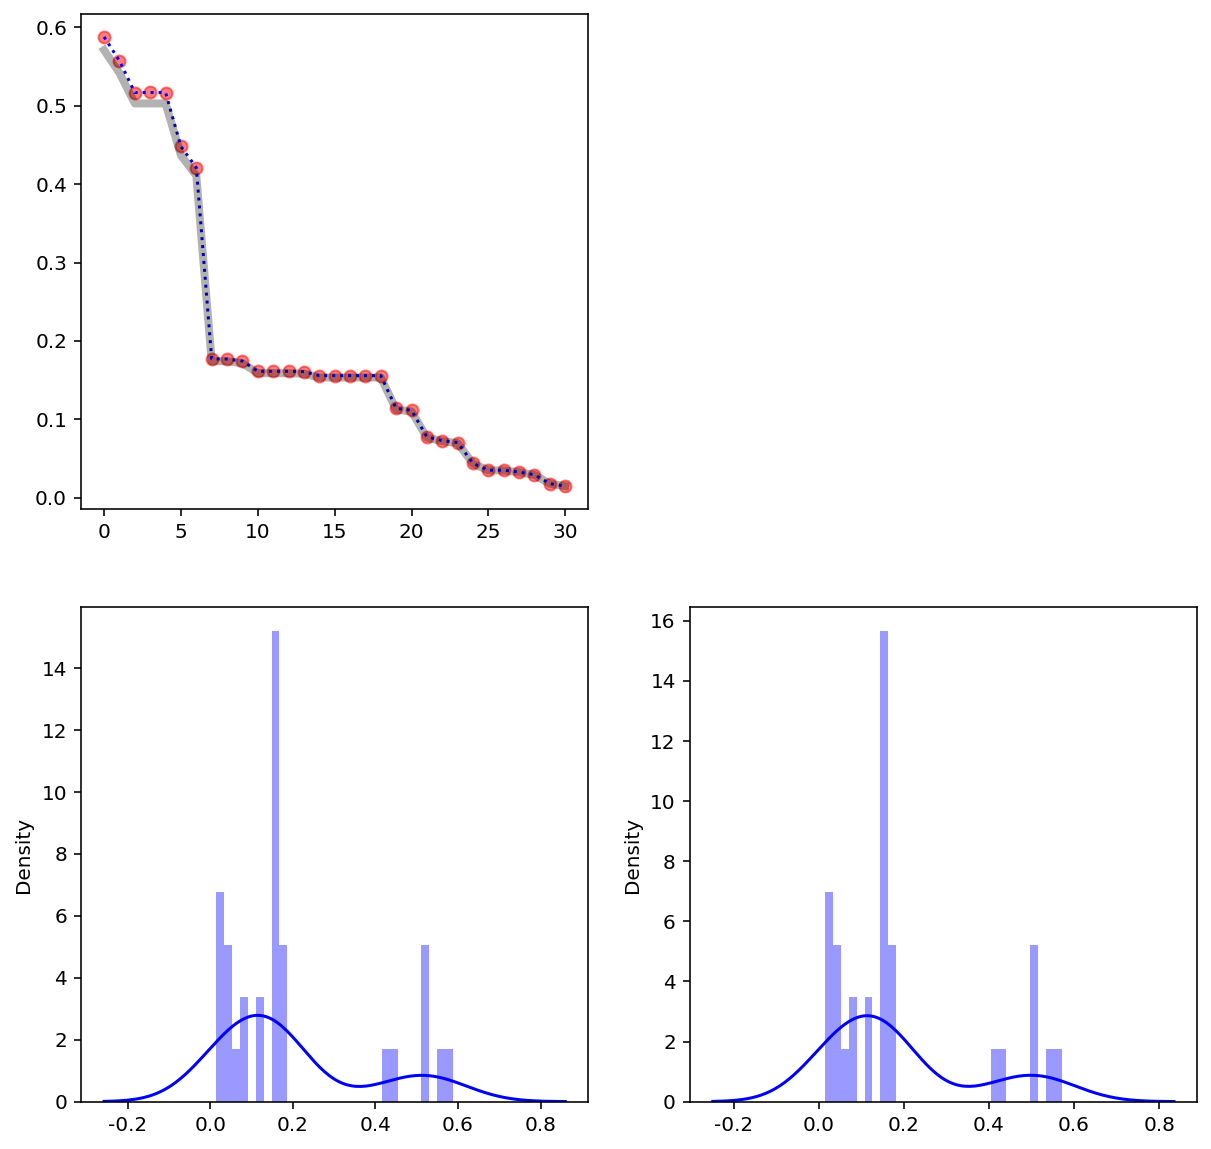

In [257]:
plt.figure(figsize=(10, 10))
t0 = [np.square(x + y) for x, y in zip(list(cosim_df[0]), [(n/len(model.wv.vocab)) * (1/10) for n in w2v_cosim_result])]
t = [np.square(x + y) for x, y in zip(list(cosim_df[0]), [(n/len(model.wv.vocab)) for n in w2v_cosim_result])]

plt.subplot(2, 2, 1)
plt.scatter([x for x in range(len(t))], t, color='r', alpha=0.5, zorder=1)
plt.plot([x for x in range(len(t))], t, color='b', linestyle=':', zorder=2)
plt.plot([x for x in range(len(t0))], t0, color='black', linewidth=4, alpha=0.3, zorder=3)

plt.subplot(2, 2, 3)
sns.distplot(t, bins=30, color='b')

plt.subplot(2, 2, 4)
sns.distplot(t0, bins=30, color='b')

plt.show()

In [258]:
print(tk_extra_f_w2v)
print()

All_Contents

['마스크의', '펩타이드', '히비스커스', '미라클', '나이트', '황금향', '피토플라센타', '스네일', '콜라겐', '허브', '가득한', '프로폴리스', '비타민', '블룸', '리페어', '컨센트레이트', '로즈힙', '티트리', '히알루론산', '알로에', '멀티', '동백', '블랙티', '피토', 'step', '허브스킨워터', '앰플', '곰의']



['[] 허브 가득한 마스크',
 '허브 가득한 마스크 블랙티',
 '허브 가득한 마스크 카렌듈라',
 '허브 가득한 마스크 연꽃',
 '허브 가득한 마스크 히비스커스',
 '허브 가득한 마스크 피오니',
 '허브 가득한 마스크 티트리',
 '허브 가득한 마스크 로즈힙',
 '제주 가득한 마스크 알로에',
 '제주 가득한 마스크 그린티',
 '앰플 가득한 마스크 히알루론산',
 '앰플 가득한 마스크 프로폴리스',
 '앰플 가득한 마스크 콜라겐',
 '앰플 가득한 마스크 펩타이드',
 '앰플 가득한 마스크 피토플라센타',
 '제주 가득한 마스크 황금향',
 '제주 가득한 마스크 유채꿀',
 '제주 가득한 마스크 동백',
 '제주 가득한 마스크 감태',
 '제주 가득한 마스크 청보리',
 '앰플 가득한 마스크 세라마이드',
 '앰플 가득한 마스크 멀티 비타민',
 '로즈 허브스킨워터',
 '그린티 허브스킨워터',
 '카렌듈라 허브스킨워터',
 '로터스 아쿠아 블룸 마스크',
 '피토 아쿠아 3 step 마스크',
 '피토 아쿠아 나이트 마스크',
 '머쉬룸 리페어 마스크',
 '미라클 포레스트 컨센트레이트 마스크',
 '해피 스네일 하이드로겔 마스크',
 '마스크의 신 곰의 피부 비법']

##### ***- Pause***

In [38]:
null_lst = []
for i, row in df_optional.iterrows():
    if row.type_color == []:
        null_lst.append(i)      
        
# ------------------------------------------ 학습 데이터 셋 추출_ 1차
x = df_optional.type_color[null_lst].index.tolist()
y = [fl_nv_dt_or_res.index == x for x in x]

res = [fl_nv_dt_or_res[y[i]] for i in range(len(x))]
res_no_options = pd.concat(res)

# ------------------------------------------ 유사도 검출 및 저장
# res_similarity_V1 = []
# for i in tqdm(range(len(res_no_options))):
#     res_similarity_V1.append(Getting_Similarity_Chart(res_no_options, i))

In [ ]:
with open('res_similarity_V1.txt', 'wb') as fp:
    pickle.dump(res_similarity_V1, fp)

In [ ]:
with open('res_similarity_V1.txt', 'rb') as fp:
    res_similarity_V1_ = pickle.load(fp)

In [ ]:
Compared_Res_1 = []
for i in range(len(res_similarity_V1_)):
    if len(res_similarity_V1_[i]) == 0:
        Compared_Res_1.append([])
    elif len(res_similarity_V1_[i]) == 1:
        Compared_Res_1.append(res_similarity_V1_[i].Comparative_original.tolist()[0])
    elif (len(res_similarity_V1_[i]) >= 2) and (res_similarity_V1_[i].Cosine_Similarity[0] != res_similarity_V1_[i].Cosine_Similarity[1]):
        Compared_Res_1.append(res_similarity_V1_[i].Comparative_original[0])
    elif (len(res_similarity_V1_[i]) >= 2) and (res_similarity_V1_[i].Cosine_Similarity[0] == res_similarity_V1_[i].Cosine_Similarity[1]):
        Compared_Res_1.append(list(res_similarity_V1_[i][res_similarity_V1_[i].Cosine_Similarity == res_similarity_V1_[i].Cosine_Similarity[0]].Comparative_original))
    else:
        Compared_Res_1.append([])

In [ ]:
print('\t - Structure of trained data', len(Compared_Res_1))

	 - Structure of trained data 20263


<span style="color:blue">***학습 완료데이터 V1 엑셀파일로 추출 (Purpose Of Quality Check)***</span>

In [ ]:
res_no_options_ = res_no_options.copy()
res_ind = res_no_options_.index.tolist()

nv_filtered = []
for i in res_ind:
    nv_filtered.append(fl_nv_dt_or_cp_V[fl_nv_dt_or_cp_V.index == i])
    
nv_filtered_df = pd.concat(nv_filtered)    

nv_filtered_df_ = nv_filtered_df.loc[:, ['title', 'link', '브랜드']]
nv_filtered_df_['gf_mappeed'] = Compared_Res_1
nv_filtered_df_.tail(1)

,title,link,브랜드,gf_mappeed
32463,스킨구하리 / ATL 릴리프 로션 / 200ml,https://shopping.naver.com/beauty/stores/10109...,스킨구하리,ATL 릴리프 로션


In [ ]:
nv_filtered_df_.to_excel(str(os.getcwd() + '/' + 'mapping_gf.xlsx'))

---

##### ***- Baysian Switch Point Trial***


In [328]:

observed_counts = tf.concat(
    [tfd.Poisson(rate).sample(num_steps) 
    for (rate, num_steps) in zip([x*10000 for x in w2v_cosim_result], np.repeat(100, len(w2v_cosim_result), axis=0))], axis=0)
observed_counts = tf.cast(observed_counts, dtype=tf.float32)
df = pd.DataFrame(observed_counts)
fig = px.line(df, y=0)

fig.update_layout(
    autosize=False,
    width=300,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

Text(0, 0.5, 'Negative log marginal likelihood')

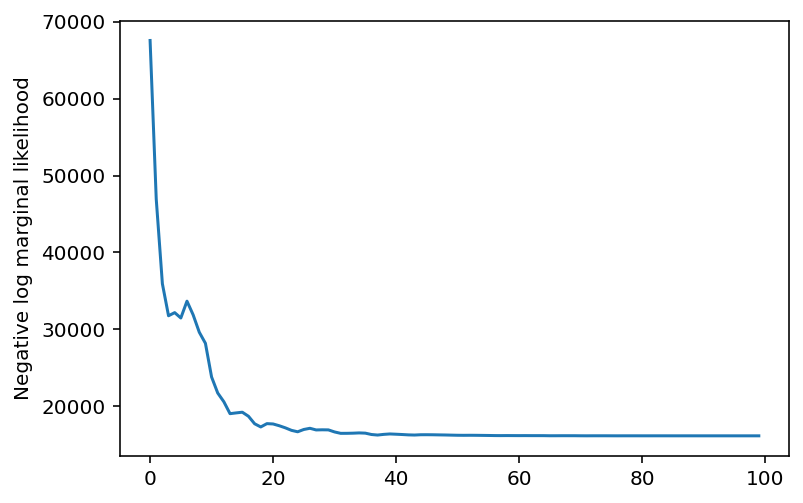

In [329]:
num_states = len(w2v_cosim_result)
initial_state_logits = tf.zeros([num_states]) 
change_prob = 0.05
transition_probs = tf.fill([num_states, num_states], change_prob / (num_states - 1))
transition_probs = tf.linalg.set_diag(transition_probs, tf.fill([num_states], 1 - change_prob))

x = tf.math.log(tf.reduce_mean(observed_counts))
x = tf.cast(x, dtype=tf.float32)
trainable_log_rates = tf.Variable( x + tf.random.stateless_normal([num_states], seed=(42, 42) ), name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

losses = tfp.math.minimize(
    lambda: -log_prob(), optimizer=tf.optimizers.Adam(learning_rate=0.1), num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

In [332]:
rates = tf.exp(trainable_log_rates)

most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = tf.gather(rates, most_probable_states)

In [358]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=most_probable_rates, name='inferred rate', line_shape='linear', line_color='blue'))
fig.add_trace(go.Scatter(y=observed_counts, name='observed counts', line_shape='linear', line_color='black', opacity=0.3))

fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

In [375]:
list(most_probable_rates)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=5794.9795>

In [436]:
# lst  = sorted(list(set(np.array(most_probable_rates))), reverse=True)
diff = [abs(lst[x] - lst[x-1]) for x in range(1, len(lst))]
ind = diff.index(max(diff))
lst[ind - 2] / 10000 

0.508915625

In [435]:
lst[3] / 10000 

0.444879150390625

In [434]:
w2v_cosim_result

[0.5787822382978544,
 0.5463245009565193,
 0.5074553954903751,
 0.510491237470416,
 0.5074553954903751,
 0.443942551877716,
 0.4179114993249615,
 0.1774571450833579,
 0.17566909063070957,
 0.17660190111551874,
 0.1637164990847015,
 0.1637164990847015,
 0.1637164990847015,
 0.1648893458393392,
 0.15655384582171417,
 0.1548746754855024,
 0.15655384582171417,
 0.1548746754855024,
 0.1548746754855024,
 0.11525962578826561,
 0.11569347875693246,
 0.07908524909018887,
 0.07436990968422375,
 0.07195787755632109,
 0.04433618763928671,
 0.03648757261761064,
 0.03648757261761064,
 0.0333173361943994,
 0.030586196293187977,
 0.01846136740838555,
 0.015932879563309382]